### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, 1024)]

In [4]:
data = pd.read_csv('data/sacharose_1000/all.csv', sep = '\t').iloc[:,:-1]

In [5]:
data.columns = names

In [6]:
def load_spectrum(data, moment_of_time):
    ppm = data['ppm']
    intensity = data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    return sp

### Components

In [ ]:
load

In [7]:
sacharose = pd.read_csv('data/sacharose_1000/sucrose.csv', sep = '\t', header=None).iloc[:,:-1]
glucose = pd.read_csv('data/sacharose_1000/glucose.csv', sep = '\t', header=None).iloc[:,:-1]
fructose = pd.read_csv('data/sacharose_1000/fructose.csv', sep = '\t', header=None).iloc[:,:-1]

all_substances = [sacharose, glucose, fructose]

In [8]:
spectra = []
for sub in all_substances:
    ppm = sub[0]
    ints = sub[1]
    sp = NMRSpectrum(confs = list(zip(ppm, ints)))
    sp.trim_negative_intensities()
    sp.normalize()
    spectra.append(sp)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


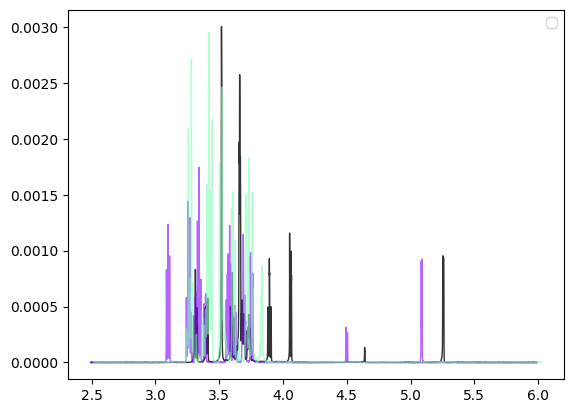

In [9]:
NMRSpectrum.plot_all(spectra, profile=True)

In [10]:
substrat_1 = spectra[0]
product_1 = spectra[1]
product_2 = spectra[2]

### Estimation

In [15]:
kappa = 0.25
kappa_th = 0.25

In [16]:
proportions_in_times = []
noise_proportions_in_times = []

sp1 = load_spectrum(data, 1)
sp1.trim_negative_intensities()
sp1.normalize()

for i in range(1, 1024):
    print('This is timepoint '+str(i)+'.\n')
    mix = load_spectrum(data, i)
    estimation = estimate_proportions(mix, [substrat_1, product_1, product_2], what_to_compare='area', 
                                      solver=pulp.GUROBI(msg=False),
                                     MTD=kappa, MTD_th=kappa_th)
        
    proportions_in_times.append(estimation['proportions'])
    noise_proportions_in_times.append(estimation['proportion_of_noise_in_components'])
    
    print('Proportions:\n')
    print(estimation['proportions'])
    print('\n')
    print('Proportion_of_noise_in_components:\n')
    print(estimation['proportion_of_noise_in_components'])
    print('\n')

This is timepoint 1.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.

Interrupt request received
Proportions:

[0.6193326316079215, 0.15497179419802906, 0.12337702304694315]


Proportion_of_noise_in_components:

0.00032130873671445834


This is timepoint 2.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.6221858216556088, 0.14704320308338747, 0.13259567842828285]


Proportion_of_noise_in_components:

0.0005949338695686207


This is timepoint 3.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.6246461571455694, 0.1667020313379444, 0.1037347180576103]


Proportion_of_noise_in_componen

Proportions:

[0.6199788628948253, 0.16968227532269872, 0.10989054709733968]


Proportion_of_noise_in_components:

0.00031705875251606427


This is timepoint 26.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.6269917120457867, 0.17415974562066633, 0.09077607066341915]


Proportion_of_noise_in_components:

0.0003781021773245648


This is timepoint 27.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.6208597453500919, 0.16879114690986793, 0.10720666970264355]


Proportion_of_noise_in_components:

0.0003672263472775688


This is timepoint 28.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spec

TypeError: type NoneType doesn't define __round__ method

In [11]:
len(proportions_in_times)

1023

In [12]:
max([prop[0] for prop in proportions_in_times])

1.0000000000000104

In [13]:
min([prop[0] for prop in proportions_in_times])

0.9919221290140025

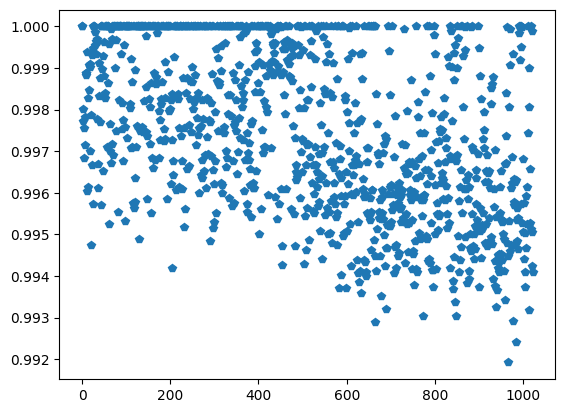

In [14]:
plt.plot(range(len(proportions_in_times)), [prop[0] for prop in proportions_in_times], 'p')

In [15]:
prop = [prop[0] for prop in proportions_in_times]

In [16]:
with open('results/sacharose_1000/comparing_with_first/known_substrats/proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(prop, f)

In [17]:
with open('results/sacharose_1000/comparing_with_first/known_substrats/noise_proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_proportions_in_times, f)

### Linear regression

In [18]:
with open(r'results/sacharose_1000/comparing_with_first/known_substrats/proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y).reshape(-1,1)

In [19]:
t = np.array(range(1,1024))
t_and_ones = np.vstack([t, np.ones(len(t))]).T

In [22]:
slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]

/tmp/ipykernel_3869/1288480160.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]


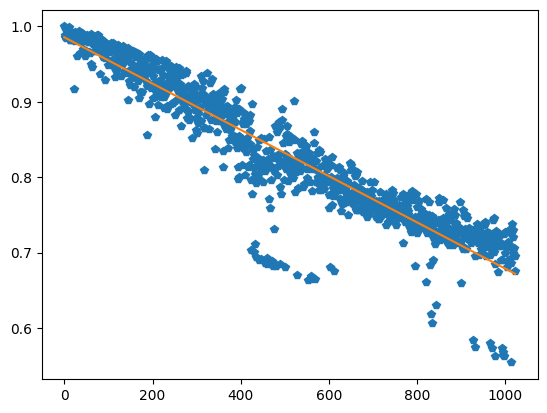

In [23]:
plt.plot(range(len(y)), [prop[0] for prop in y], 'p')
plt.plot(slope*t+intercept)